In [2]:
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
%matplotlib inline

### Tratado de los datos 

In [3]:
def tratadoDatos(dataset,modificarColumnas,eliminarColumnas):
    data =pd.read_csv(dataset,encoding='latin-1')
    columna = data.columns
    for index in modificarColumnas:
        name = columna[index]
        value = list(data[name].unique())
        data[name] = data[name].map(dict(zip(value,[i for i in range(len(value))])))
    #print(data.head())
    data = data.drop([columna[index]for index in eliminarColumnas], axis=1)
    valor_media=data.select_dtypes(include=['number']).mean()
    data = data.fillna(valor_media.round(2))
    return data

In [4]:
def DatosSinteticos(data,listaData,n_filas,clases):
    nuevos_datos=np.empty([n_filas,len(data.columns)])
    ColmunaY = np.random.randint(0,clases, n_filas)
    #print(ColmunaY)
    for i in range(len(data.columns)-1):
        for j in range(0,n_filas):
            pos=ColmunaY[j]
            columna_i =listaData[pos].iloc[:,i]
            muestras_i=np.random.choice(columna_i,1,replace=True)

            pro_cambio = random.random()
            decision = random.randint(0, 1)
            if pro_cambio < 0.2:
               muestras_i = muestras_i + pro_cambio if decision == 0 else muestras_i - pro_cambio

            if(i == 0):
                muestras_i=muestras_i.round(5)
            else:
                muestras_i=muestras_i.round(2)
            #np.random.seed()
            nuevos_datos[j:,i]=muestras_i
            nuevos_datos[j:,len(data.columns)-1]=ColmunaY[j]
    columnas =list(data.columns)
    print(nuevos_datos)
    nuevos_datos_data=pd.DataFrame(nuevos_datos,columns=columnas)
    dataExtend =pd.concat([data,nuevos_datos_data],axis=0)
    #print(dataExtend.tail())
    return dataExtend

In [5]:
def listaDataframes(data,clases,columna_y):
    ListaData=[]
    for i in range(0,clases):
        ListaData.append(data[data[columna_y] == i])
    return ListaData

In [6]:
def col_categoricas(ruta):
    data =pd.read_csv(ruta)
    columnas_numericas = data.select_dtypes(include=['object'])
    col_numericas = np.array([data.columns.get_loc(col) for col in columnas_numericas.columns])
    return col_numericas

In [7]:
def num_clasificaciones(data,columnay):
    value = list(data[columnay].unique())
    print("clases :",value)
    print('Cantidad:',len(value))
    data.info()

In [8]:
def reorganizarDataset(data, posicion_columna):
    # Obtener el nombre de la columna a mover
    nombre_columna = data.columns[posicion_columna]

    # Crear una lista con las columnas en el nuevo orden
    columnas_nuevas = list(data.columns[:posicion_columna]) + list(data.columns[posicion_columna+1:]) + [nombre_columna]
    
    # Crear un nuevo DataFrame con las columnas reorganizadas
    data_reorganizado = data[columnas_nuevas]
    
    return data_reorganizado

### Algortimo Descenso de Gradiente Clasificacion Binaria

In [9]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)
  
    g = np.zeros(z.shape)

    g = 1 / (1 + np.exp(-z))

    return g

In [10]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    
    return J

In [11]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento
    
    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []
    
    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)
       
        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

###  Clasificacion Binaria usando `scipy.optimize`
En el codigo anterior se encontró los parámetros óptimos usanod el modelo de regresion lineal al implementar el descenso de gradinte
ahora se va usar la bilblioteca de scipy.optimize ,Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

In [12]:
def costFunction(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)
    
    return J, grad

In [13]:
# Inicializacion de parametros de ajuste
def parametro_de_aprendisaje(X,y,n):
    initial_theta = np.zeros(n+1)
    print(initial_theta)
    cost, grad = costFunction(initial_theta, X, y)
    return cost, grad,initial_theta


In [46]:
# Establecer las opciones para optimize.minimize
def funcionOptimize(initial_theta,X,y):
    options= {'maxfun': 1000}

    # revisar la documentacion de scipy's optimize.minimize para mayor descripcion de los parametros
    # La funcion devuekve un objeto `OptimizeResult`
    # Se utiliza el algoritmo de Newton truncado para la optimización.
    res = optimize.minimize(costFunction,
                            initial_theta,
                            (X, y),
                            jac=True,
                            method='TNC',
                            options=options)

    # la propiedad fun del objeto devuelto por `OptimizeResult`
    # contiene el valor del costFunction de un theta optimizado
    cost = res.fun

    # Theta optimizada esta en la propiedad x
    theta = res.x

    # Imprimir theta en la pantalla
    print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))

    print('theta:')
    #print('\t[{:.3f},]'.format(*theta))
    print(theta)
    return cost,theta


In [15]:
#evaluacion dela regresion logistica
def predict(theta, X):
    """
    Predecir si la etiqueta es 0 o 1 mediante regresión logística aprendida.
    Calcula las predicciones para X usando un umbral en 0.5 (es decir, si sigmoide (theta.T * x)> = 0.5, predice 1)

    Parametros
    ----------
    theta : array_like
        Parametros para regresion logistica. Un vecto de la forma (n+1, ).
    
    X : array_like
        Datos utilizados para el calculo de las predicciones. 
        La fila es el numero de los puntos para calcular las predicciones, 
        y las columnas con el numero de caracteristicas.

    Devuelve
    -------
    p : array_like
        Predicciones y 0 o 1 para cada fila en X. 
    """
    m = X.shape[0] # Numero de ejemplo de entrenamiento

    p = np.zeros(m)

    p = np.round(sigmoid(X.dot(theta.T)))
    return p

### Preparar Dataset

In [23]:
data=pd.read_csv('./Data/data03_entrenamiento_satisfacion_servisio_aerolinea.csv')
#data.info()
num_clasificaciones(data,'satisfaction')

clases : ['neutral or dissatisfied', 'satisfied']
Cantidad: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 

In [25]:
#data = data.fillna(data.mean)
#data['salario'] = data['salario'].fillna(100) #esto es para rellenar valores nulos en una columna especifica
rutadatset='./Data/data03_entrenamiento_satisfacion_servisio_aerolinea.csv'
col_categoricas(rutadatset)
data=tratadoDatos(rutadatset,[ 2,  3,  5,  6, 24],[0,1,11])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  int64  
 1   Customer Type                      103904 non-null  int64  
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  int64  
 4   Class                              103904 non-null  int64  
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Food and drink                     103904 non-null  int64  
 10  Online boarding                    103904 non-null  int64  
 11  Seat comfort                       1039

In [26]:
#num_clasificaciones(data,'Segmentation')
#Reorganizar las columnas
#datar=reorganizarDataset(data,8)
#datar.head()
#Listadata=listaDataframes(data,4,'Segmentation')
#data=DatosSinteticos(data,Listadata,5000,4)
#generar un nuevo archivo cvs del nuevo dataset con datos sinteticos
#data.to_csv('TrainSinteticos.csv',index=False)

In [27]:
#separar columna objetivo del dataFrame para X  y asignar objetivo a Y
def segmantacion(data,columnay):
    X = data.drop(columnay, axis=1)
    y = data[columnay]
    X_entre, X_prueba, y_entre, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_entre.to_numpy(), y_entre.to_numpy(),X_prueba.to_numpy(),y_prueba.to_numpy()

In [28]:
X_entre,y_entre,X_prueba,y_prueba=segmantacion(data,'satisfaction')
num_labels = 4
print('Entrenamiento:',X_entre.shape,y_entre.shape,'Prueba:',X_prueba.shape,y_prueba.shape)

#concatenar el 1 en X de entramiento
m, n = X_entre.shape
me=X_prueba.shape[0]
# Agraga el termino de intercepción a A
X_entre = np.concatenate([np.ones((m, 1)), X_entre], axis=1)
X_prueba = np.concatenate([np.ones((me, 1)), X_prueba], axis=1)
print(X_entre[0])

Entrenamiento: (83123, 21) (83123,) Prueba: (20781, 21) (20781,)
[1.000e+00 1.000e+00 0.000e+00 5.900e+01 0.000e+00 2.000e+00 1.046e+03
 4.000e+00 5.000e+00 4.000e+00 5.000e+00 4.000e+00 5.000e+00 2.000e+00
 2.000e+00 4.000e+00 3.000e+00 5.000e+00 2.000e+00 4.000e+00 1.200e+01
 3.000e+00]


### Resultados usando descenso por gradiente

0.6891788605088415


Text(0, 0.5, 'Costo J')

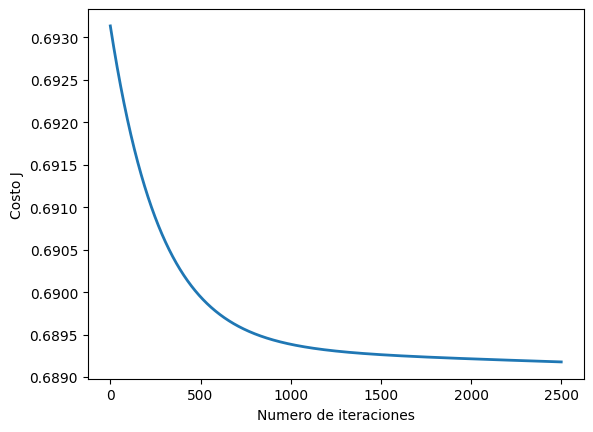

In [32]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.000000003
num_iters = 2500

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(22)
theta, J_history = descensoGradiente(theta, X_entre, y_entre, alpha, num_iters)
print(J_history[-1])
# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

In [43]:
#prediccion para un valor
fila=69
Xp=X_prueba[fila:fila+1,:].copy()
print("valor esperado :",y_prueba[5])
aprueba = sigmoid(np.dot(Xp, theta))   # Se debe cambiar esto
print('prediccion (usando el descenso por el gradiente)',aprueba)
print('prediccion falso o verdadero es (usando el descenso por el gradiente):{:.0f}'.format(np.squeeze(aprueba)))


valor esperado : 0
prediccion (usando el descenso por el gradiente) [0.52982862]
prediccion falso o verdadero es (usando el descenso por el gradiente):1


### Resultados usando Optimizee de cypes.optimize

In [48]:
cost,grad,initial_theta=parametro_de_aprendisaje(X_entre,y_entre,n)
costo,theta=funcionOptimize(initial_theta,X_entre,y_entre)
print("valor esperado :",y_prueba[5])
prob = sigmoid(np.dot(Xp, theta))
print('Prediccion : {:.3f}%'.format(np.squeeze(prob)))

# Compute accuracy on our training set
p = predict(theta, X_entre)
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y_entre) * 100))

#print(Xp)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Costo con un valor de theta encontrado por optimize.minimize: 0.338
theta:
[-9.23929266e+00 -6.25828575e-02 -2.03244262e+00 -7.55717050e-03
  3.05194243e+00 -1.92803706e-01  8.71159940e-05  3.40604372e-01
 -1.11009740e-01 -1.21570154e-01 -1.51631563e-02  6.39660908e-01
  8.91748081e-02  2.69581034e-02  3.30614048e-01  2.58483836e-01
  1.54269636e-01  3.37513814e-01  1.40479039e-01  2.14833196e-01
  4.40942486e-03 -9.29881129e-03]
valor esperado : 0
Prediccion : 0.014%
Precisión de entrenamiento: 87.32 %
